# OpFlow domain-decomposed 1D experiment

For domain-decomposed OpFlow, we suggest working on the same resolution for learning the prior (from generation tasks) and regression. This is because, we observe artifacts during zero-shot super-resolution for domain-decomposed OpFlow. However, for codomain OpFlow, we don't have such restriction. To explain this, here are two examples:

(1) Regression using 1D domain-decomposed OpFlow on a resolution of 128 requires a prior trained on a resolution of 128. (The regression can take prior trained on other resolutions, but the performance cannot be guaranteed)\
(2) Regression using 1D codomain-decomposed OpFlow on a resolution of 128 can take prior trained on any resolutions (64,96,128,256,...)

But we should notice, domain-decomposed OpFlow has greater expressiveness compared to codomain OpFow, which can be applied to more challenging tasks when codomain OpFlow may fail

### load necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
import timeit

from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm


In [2]:
import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = "4"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

### dataset parameters and preparation

In [3]:
# data size and dimension
ntrain = 30000
ndim = 128
batch_size = 512

## matern kernel parameter 
length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.1
nu_z = 0.5

In [4]:
x = np.linspace(0, 1, ndim)
X = x.reshape(-1, 1) # inquired positions
bound_value = 1.2
ub_value = bound_value
lb_value= -bound_value

In [5]:
def reject_resample(X, gpr_model, lb_value, ub_value, num=5000):
    # based on the resample strategy 
    samples = 0
    y_tr_samples = []
    
    while samples < num:
        y_samples = gpr_model.sample_y(X, num, random_state=None)[:,:,np.newaxis]

        logic_value = (y_samples <= ub_value) & (y_samples >=lb_value)
        pass_id = np.all(logic_value, axis=0)

        n_generated = y_samples[:,pass_id].shape[1]
        if n_generated > 0:
            samples += n_generated 
            y_tr_samples.append(y_samples[:,pass_id])
            #print("finished {}/{}".format(samples, num))
    y_tr_samples = np.hstack(y_tr_samples)
    y_tr_samples = y_tr_samples[:,:num]
    return y_tr_samples

In [6]:
def GaussianProcess_1C(ndim, length_scale, nu, n_samples, return_kernel=False):
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)
    if return_kernel:
        return torch.tensor(y_samples), kernel(X)
    else:
        return torch.tensor(y_samples)

Starting up. Generating TGP samples
torch.Size([30000, 128, 1])


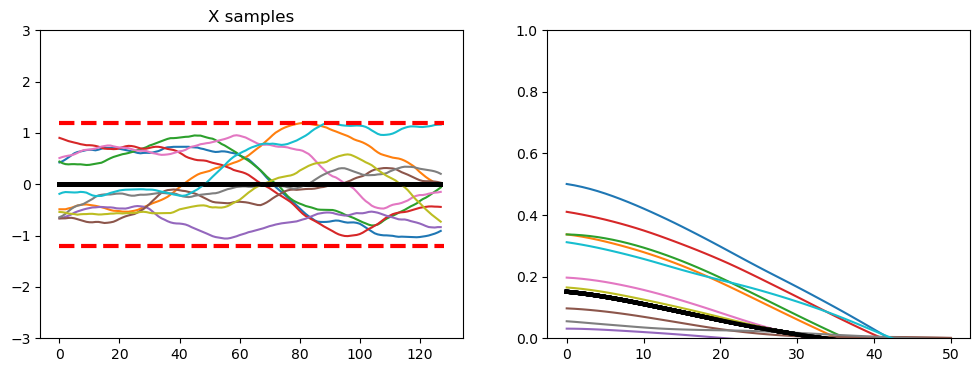

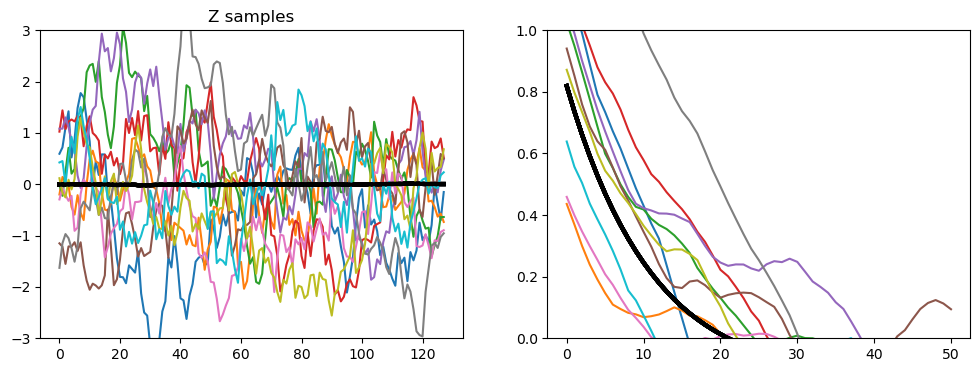

Finished sampling GRFs


In [7]:
print("Starting up. Generating TGP samples")

#np.random.seed(22)
x_kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x) 
gpr_model_x = GaussianProcessRegressor(kernel=x_kernel)

x_train = reject_resample(X, gpr_model_x, lb_value, ub_value, num=ntrain)[:,:,None]
x_train = torch.Tensor(x_train)
x_train = x_train.permute(1,0,2);

fig, ax = plt.subplots(1,2, figsize=(12,4))
x_mean_true = x_train.mean(dim=0)
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)

# calculate the autocovaraince
x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True)

print(x_train.shape)
for i in range(10):
    x = x_train[i]
    ax[0].plot(x)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(x_mean_true, c='k', lw=3)
    ax[0].set_title("X samples")
    ax[1].plot(x_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(x, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
ax[0].plot([0, ndim], [bound_value, bound_value],c='r', ls='--', lw=3)
ax[0].plot([0, ndim], [-bound_value, -bound_value],c='r', ls='--', lw=3)
plt.show()

# z smooth, length [smaller] less corrected 
z_train, kernel = GaussianProcess_1C(ndim, length_scale_z, nu_z, ntrain, return_kernel=True)
z_train = z_train.float().permute([1,0])[:,:,None]
#z_train = torch.randn(z_train.shape)
fig, ax = plt.subplots(1,2, figsize=(12,4))
z_mean_true = z_train.mean(dim=0)
z_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(z_train[i,:].numpy(), nlag=50)) for i in range(ntrain)]).mean(dim=0)
# rename as z_loader
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True)

for i in range(10):
    #x = grf.sample(1)[0,:,0]
    z = z_train[i]
    ax[0].plot(z)
    ax[0].set_ylim([-3, 3])
    ax[0].plot(z_mean_true, c='k', lw=3)
    ax[1].plot(z_acovf_true, c='k', lw=3)
    ax[1].plot(sm.tsa.acovf(z, nlag=50))
    ax[1].set_ylim([0.0, 1.0])
    ax[0].set_title("Z samples")
plt.show()
print("Finished sampling GRFs")

### OpFlow model setup

In [8]:
def kernel_loc(in_chan=1, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers


class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        #x = torch.fft.irfft(out_ft, n=x.size(-1))
        x = torch.fft.irfft(out_ft)
        return x

In [9]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes = modes
        self.width = width
        #self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 2*self.width)
        
        self.fc2 = nn.Linear(2*self.width, 2)


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=2)
        
        x = self.fc0(x)
        x = F.gelu(x)
               
        x = x.permute(0, 2, 1)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x = x.permute(0, 2, 1)
        
        x = self.fc1(x)
        x = F.gelu(x)
        
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [10]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1)).unsqueeze(0).unsqueeze(1)
            std = input.std(dim=(0,1)).unsqueeze(0).unsqueeze(1)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [11]:
class AffineCoupling(nn.Module):
    def __init__(self, modes, width, block_dim):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.modes = modes
        self.width = width
        self.coupling = FNO1d(modes=self.modes, width=self.width)
        self.actnorm = ActNorm(1)
        self.k = block_dim

    def forward(self, z, flip=False):
        #
        x = z
        x, log_actnorm = self.actnorm(x)
        n_rep = x.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=x.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:x.shape[1]]
        mask_b = torch.logical_not(mask_a)
        # define the dimension
        x1 = x * mask_a[None,:,None] # x1 has the same shape of z, but for False in mask_a, values are replaced with 0
        x2 = x * mask_b[None,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        scale_shift = self.coupling(x1)
        log_scale = scale_shift[:,:,0].unsqueeze(2)
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,1].unsqueeze(2)
        z1 = x1
        z2 = x2 * scale + shift # x2 bounded to mask_b, therefore, only parameters with mask_b are considered in loss

        z_hat = z1 + mask_b[None,:,None] * z2
        log_det = (log_scale * mask_b[None,:,None]).sum()
        log_det = log_det + log_actnorm

        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[1] // (2*self.k) + 1
        mask_a = torch.tensor([True, False], device=z.device).repeat_interleave(self.k).repeat(n_rep)
        mask_a = mask_a[:z.shape[1]]
        mask_b = torch.logical_not(mask_a)
        z1 = z * mask_a[None,:,None] 
        z2 = z * mask_b[None,:,None]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        scale_shift = self.coupling(z1)
        log_scale = scale_shift[:,:,0].unsqueeze(2)
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,1].unsqueeze(2)
        x2 = (z2 - shift) * scale
            
        x_hat = x1 + mask_b[None,:,None] * x2
        x_hat = self.actnorm.inverse(x_hat)

        return x_hat

In [12]:
class OpFlow(nn.Module):
    def __init__(self, modes, width, blocks, block_base_dim, base_dist, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = block_base_dim

        self.bijectors = nn.ModuleList([
            AffineCoupling(modes=modes, width=width, block_dim=block_dims[i]) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = self.base_dist.log_prob(z.squeeze()).sum()
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

### Training parameters

In [13]:
lr = 1e-4
epochs = 30
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

## checkboard mask stride
block_base_dim = [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2, 1, 1]
modes = ndim // 4
width = 64

blocks = len(block_base_dim)
base_mu = torch.zeros(ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [14]:
G = OpFlow(modes=modes, width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
G.train()

Number generator parameters:  7695800


OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): SpectralConv1d()
        (conv1): SpectralConv1d()
        (conv2): SpectralConv1d()
        (conv3): SpectralConv1d()
        (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (fc1): Linear(in_features=64, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO1d(
        (fc0): Linear(in_features=2, out_features=64, bias=True)
        (conv0): SpectralConv1d()
        (conv1): SpectralConv1d()
        (conv2): SpectralConv1d()
        (conv3): SpectralConv1d()
        (w0): Conv1d(64, 64, kernel_size=(1,), st

## Model training

In [15]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # usually, use should use small factor of noise
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [16]:
def is_psd(mat):
    # not used
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())

def matrix_sqrt(matrix):
    # not used
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z, base_mu, base_cov):
    """
    z : [n, ndim, 2*ndim, 1]
    base_mu : [2*ndim*ndim]
    base_cov : [2*ndim*ndim, 2*ndim*ndim]
    """

    z = z[:,:,0]
    ndim = z.shape[1]
    syn_mu = z.mean(dim=0)
    syn_cov = torch.cov(z.permute(1,0))

    """
    #print("syn_mu shape: {}, syn_cov shape : {}".format(syn_mu.shape, syn_cov.shape))

    if base_cov_sqrt is None:
        base_cov_sqrt = matrix_sqrt(base_cov).detach()

    #print("device of syn_cov :{}, base_cov:{}, syn_cov :{}, base_cov_sqrt:{}".format(syn_cov.device, base_cov.device, syn_cov.device, base_cov_sqrt.device))
    #L = syn_cov + base_cov - 2 * matrix_sqrt(base_cov_sqrt @ syn_cov @ base_cov_sqrt).cuda()
    #term1 = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim)
    #term2 = torch.trace(L)/(ndim*ndim)
    #F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.trace(L)/(ndim*ndim)    
    """

    F2ID = torch.sum((syn_mu - base_mu)**2)/ndim + torch.sum((syn_cov -base_cov)**2)/ndim

    return F2ID

In [17]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, scheduler=None, fine_tune_epoch=10):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)
    epochs = epochs + fine_tune_epoch
    
    losses_G = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        loss_G = 0.0
 
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1
                             
        for j in range(n_train_tot):
            
            G_optim.zero_grad()

            x = get_x_batch().to(device)    
            z_syn, log_pz, log_det = G(x)            
            
            ll_loss = (-log_pz - log_det).mean()

            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss = cal_F2ID(z_syn, base_mu, base_cov)
                #loss = ll_loss + ad_loss + F2ID_loss
                loss = ll_loss + reg_fac*F2ID_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f}, loss_F2ID:{:.4f}, ".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item()))
                
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
                          
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
            
        with torch.no_grad():
            Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
            X_hat = G.inverse(Z).detach().cpu().numpy()
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            Z_alt = base_dist.rsample(sample_shape=(1000,))[:,:,None]
            X_alt = G.inverse(Z_alt).detach().cpu()
            for i in range(10):
                x = X_hat[i,:,0]
                ax[0].plot(x)
                #ax[0].set_ylim([-3, 3])
                ax[1].plot(sm.tsa.acovf(x, nlag=50))
                #ax[1].set_ylim([0.0, 1.0])
                x_mean = X_alt.mean(dim=0)
                x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=50)) for i in range(1000)]).mean(dim=0)
                ax[0].plot(x_mean_true, c='k', lw=3, label='Ground Truth')
                ax[1].plot(x_acovf_true, c='k', lw=3, label='Ground Truth')
                ax[0].plot(x_mean, c='r', lw=3, label='OpFlow')
                ax[1].plot(x_acovf, c='r', lw=3, label='OpFlow')
                
                if i == 0:
                    ax[0].legend(loc='upper right')
                    ax[1].legend(loc='upper right')
            plt.savefig("../paper_plots/{}/1D_domain_decomposed_TGP_{}_prior.pdf".format(folder, epoch))
            plt.close()
      
        #losses_D[epoch] = loss_D / batch_size
        losses_G[epoch] = loss_G / batch_size
        
        if ((epoch+1)%400 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "../paper_saved_models/{}/1D_domain_decomposed_TGP_{}_prior.pt".format(folder, epoch))
        
    return losses_G

In [18]:
folder = "GP2TGP_FNO_domain_decomposed_prior"
if not os.path.exists(f"../paper_saved_models/{folder}"):
    os.makedirs(f"../paper_saved_models/{folder}")
if not os.path.exists(f"../paper_plots/{folder}"):
    os.makedirs(f"../paper_plots/{folder}")

In [ ]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

## Validation

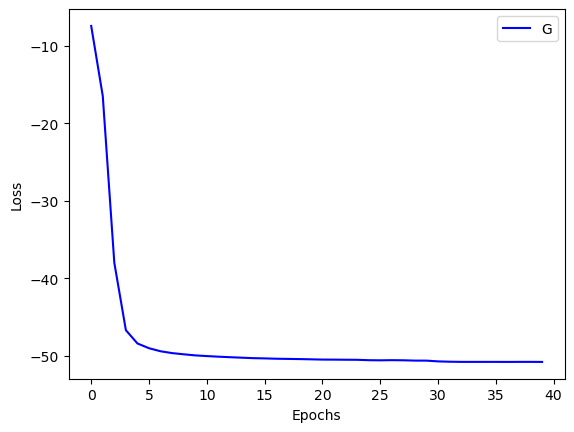

In [20]:
plt.plot(np.arange(epochs+10), losses_G, c='b', label='G')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
folder = "GP2TGP_FNO_domain_decomposed"
if not os.path.exists(f"../paper_pdf/{folder}"):
    os.makedirs(f"../paper_pdf/{folder}")

In [18]:
# load trained model
G = OpFlow(modes=modes, width=width, blocks=blocks,block_base_dim=block_base_dim, base_dist=base_dist).to(device)
# paper plot, model_path = 'paper_saved_models/GP2TGP_FNO_domain_decomposed/1D_domain_decomposed_TGP_449_set1.pt'

model_path = f"../paper_saved_models/{folder}/1D_domain_decomposed_TGP_39_prior.pt"'"
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

In [ ]:
model=G

## statistical comparison

In [21]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
nlag_eva = int(ndim//2)

x_pos = np.linspace(0, 1, ndim)
x_pos_acovf = x_pos[:nlag_eva]

nsample_eva = 5000

x_acovf_true = torch.stack([torch.tensor(sm.tsa.acovf(x_train[i,:].numpy(), nlag=nlag_eva-1)) for i in range(ntrain)]).mean(dim=0)

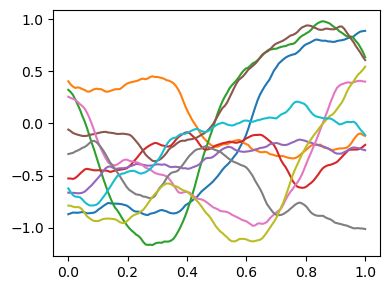

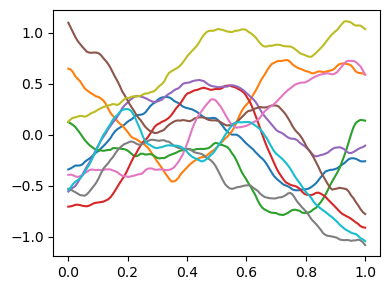

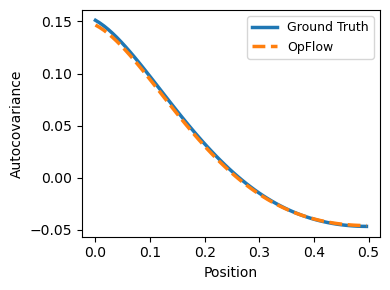

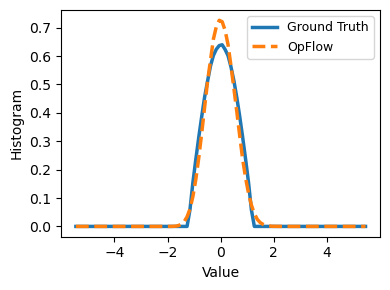

In [24]:
with torch.no_grad():
    Z = base_dist.rsample(sample_shape=(10,))[:,:,None]
    X_hat = model.inverse(Z).detach().cpu().numpy()
    X_ground_truth = x_train[:10]
    # plot

    Z_alt = base_dist.rsample(sample_shape=(nsample_eva,))[:,:,None]

    z_train_iter = torch.split(z_train, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)           
    x_hist, bin_edges_alt = X_alt.histogram(range=[-5.5,5.5], density=True)  
    
    # save the figure for Ground Truth
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    for i in range(10):
        x_ground_truth = X_ground_truth[i,:,0]
        ax.plot(x_pos, x_ground_truth)
        #ax.set_title('Ground Truth')
    plt.tight_layout()
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_ground_truth.pdf")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))    
    for i in range(10):
        x = X_hat[i,:,0]
        ax.plot(x_pos, x)
        #ax.set_title('OpFlow Generated')
    plt.tight_layout()
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples.pdf")
    
    #x_mean = X_alt.mean(dim=0)
    x_acovf = torch.stack([torch.tensor(sm.tsa.acovf(X_alt[i,:,0], nlag=nlag_eva-1)) for i in range(nsample_eva)]).mean(dim=0)
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos_acovf, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos_acovf, x_acovf, c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    ax.set_xlabel('Position')
    ax.set_ylabel('Autocovariance')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    ax.set_xlabel('Value')
    ax.set_ylabel('Histogram')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_hist.pdf")